In [79]:
import sys
import os



# Add the parent directory to sys.path so Python can find the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [80]:
from EKI.eki import*
from EKI.stopping_rules import*
from EKI.uq import*
from ForwardModels.models import*


In [81]:
forward_model = LinearForwardModel(3, 3, 2, coef=jnp.pi**(-2))

In [82]:
forward_model.operator

Array([[0.10132118, 0.        , 0.        ],
       [0.        , 0.0253303 , 0.        ],
       [0.        , 0.        , 0.01125791]], dtype=float32)

In [129]:
def main():
    """Run a simple EKI example."""
    # Set random seed for reproducibility
    key = random.PRNGKey(42)

    # Problem dimensions
    dim_parameters = 5
    dim_observations = 3
    p = 2
    beta = 3/2
    num_particles = 50

    forward_model = LinearForwardModel(dim_parameters, dim_observations, p, coef=jnp.pi**(-2))
    i_array = jnp.linspace(1, dim_parameters, dim_parameters)
    f0 = jnp.apply_along_axis(lambda x: x ** (-beta), 0, i_array)



    y_true = forward_model.evaluate(f0[:, jnp.newaxis])[:, 0]

    # Add noise to observations
    noise_level = 1e-6
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise
    prior_cov = GaussianKernel(dim_parameters, 2)._operator_fourier
    # Initialize EKI solver
    eki = EKI(
        forward_model=forward_model,
        observations=observations,
        dim_parameters=dim_parameters,
        num_particles=num_particles,
        init_covariance=prior_cov,
        init_mean=jnp.zeros(dim_parameters),
        noise_level=noise_level,
        time_interval=(0.0, 150.0, 200),  # (start, end, max_steps)
        rng_key=key,
    )

    # Create stopping rule: Discrepancy principle
    stopping_rule = DiscrepancyPrinciple(
        effective_dim=dim_observations,
        tolerance=noise_level,
        kappa=0.5,
        max_iterations=100,
    )

    # Run the algorithm with early stopping
    results = eki.fit(stopping_rule=stopping_rule)

    # Print results
    print(f"\nAlgorithm converged: {results['converged']}")
    print(f"Stopping time: {results['stopping_time']}")
    print(f"Final residual: {results['final_residual']:.6f}")

    return results, f0


In [130]:
results, f0 = main()

0
1
2
3
4
converged

Algorithm converged: True
Stopping time: 4
Final residual: 0.000798


In [131]:
len(results["ensemble_history"])

5

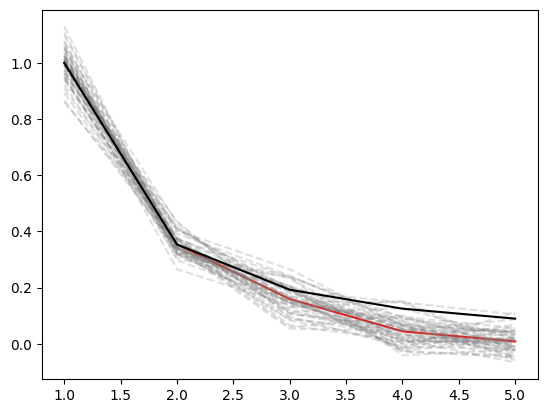

In [133]:
i_array = jnp.linspace(1, 5, 5)

plt.plot(i_array, jnp.mean(results["ensemble_history"][-1], axis=1), color="red")
plt.plot(i_array, results["ensemble_history"][-1], color="grey", linestyle="dashed", alpha=0.25)
plt.plot(i_array, f0, color="black")
plt.show()